# Surfers cluster

## Packages importing

In [1]:
import numpy as np
import torch
import shutil
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import AutoImageProcessor, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from scipy import stats


model_ckpt = "facebook/dinov2-base"
extractor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

# Set up paths and parameters
IMAGE_FOLDER = "./dataset/photos"
PERSON_THRESHOLD = 0.1

/Users/yvesfracari/.pyenv/versions/3.10.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [2]:
df = pd.read_csv("./dataset/annotations.csv")
df.filename = "./dataset/photos/" + df.filename
df.head()

filename person
0  ./dataset/photos/img_2863.jpg   joao
1  ./dataset/photos/img_2864.jpg   joao
2  ./dataset/photos/img_2865.jpg   joao
3  ./dataset/photos/img_2866.jpg   joao
4  ./dataset/photos/img_2867.jpg   joao

In [3]:
# Get the list of image paths
image_paths = []
for filename in os.listdir(IMAGE_FOLDER):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(IMAGE_FOLDER, filename)
        image_paths.append(image_path)
image_paths.sort()
print(f"Found {len(image_paths)} images in the folder.")

Found 317 images in the folder.


In [4]:
df.person.value_counts()

person
mina-john-rosa                 64
lucas                          59
mina-john-flores               45
bro-john-curto-moreno          43
jose                           28
bro-john-longo-listra-verde    17
mina-jhon-rosa-preto           13
joao                           12
-                              12
bro-john-curto                  9
mina-biquini-preto              8
bro-john-longo-azul             7
Name: count, dtype: int64

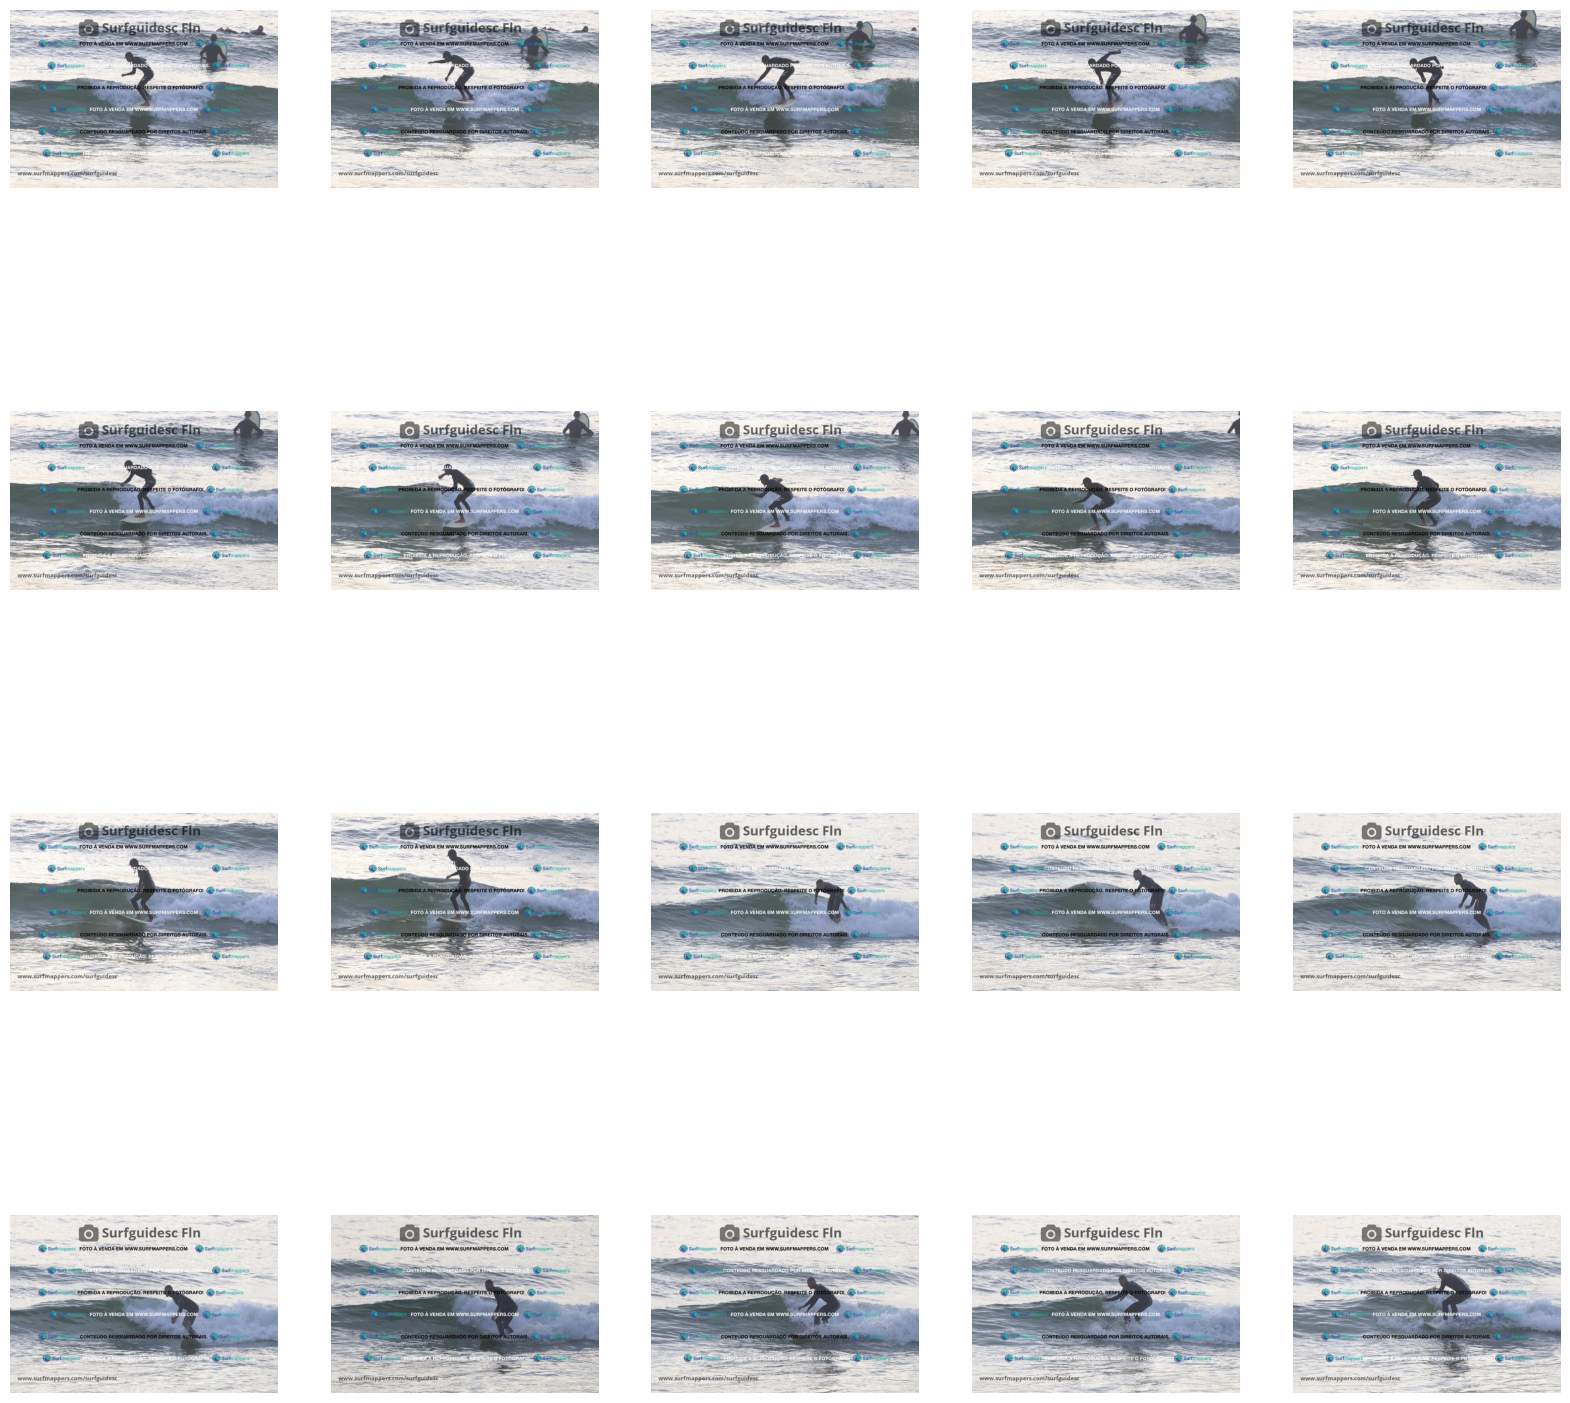

In [5]:
fig = plt.subplots(4, 5, figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image = cv2.imread(image_paths[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

**Notes**

- Labels were noted by the development team;
- Classes are unbalanced;
- Images are in a poor quality with a watermark.

## Surfer detection

**Assumptions:**
- Each photo has a core surfer
- So each photo will have one cluster

In [6]:
# Load the YOLO model for person detection
detection_model = YOLO("yolov8n.pt")


# Function to detect persons in an image
def detect_persons(image_path, model, threshold=0.4):
    results = model(image_path)
    persons = []
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        for box, cls, score in zip(boxes, classes, scores):
            if cls == 0 and score > threshold:
                persons.append((box, score))
    return persons


# Function to identify the surfer in an image
def identify_surfer(image_path, persons):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_center = np.array([width / 2, height / 2])
    min_distance = float("inf")  # Initialize with a large number
    surfer = None
    for person in persons:
        # Surfer is the person closest to the center of the image
        box = person[0]
        x1, y1, x2, y2 = box.astype(int)
        person_center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
        distance = np.linalg.norm(person_center - image_center)
        if distance < min_distance:
            min_distance = distance
            surfer = person

    # increase the bounding box size of the surfer in 20%
    if surfer is not None:
        box = surfer[0]
        x1, y1, x2, y2 = box.astype(int)
        dx = (x2 - x1) // 5
        dy = (y2 - y1) // 5
        x1 = max(0, x1 - dx)
        y1 = max(0, y1 - dy)
        x2 = min(width, x2 + dx)
        y2 = min(height, y2 + dy)
        surfer = (np.array([x1, y1, x2, y2]), surfer[1])
    return surfer

In [7]:
# Detect persons and identify surfers in each image
surfers = []
surfers_images = []
images_without_surfer = []
surfers_founded_mapping = {}

current_index = 0
for i, image_path in enumerate(image_paths):
    persons = detect_persons(image_path, detection_model, PERSON_THRESHOLD)
    surfer = identify_surfer(image_path, persons)
    surfers.append(surfer)
    # crop image with surfer bbox and show
    img = cv2.imread(image_path)
    if surfer is not None:
        x1, y1, x2, y2 = surfer[0].astype(int)
        surfer_image = img[y1:y2, x1:x2]
        surfers_images.append(surfer_image)
        surfers_founded_mapping[image_path] = current_index
        current_index += 1

    else:
        images_without_surfer.append(image_path)


image 1/1 /Users/yvesfracari/projects/surfhackers/dataset/photos/img_2863.jpg: 448x640 3 persons, 105.0ms
Speed: 4.0ms preprocess, 105.0ms inference, 7.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/yvesfracari/projects/surfhackers/dataset/photos/img_2864.jpg: 448x640 2 persons, 1 surfboard, 84.7ms
Speed: 1.2ms preprocess, 84.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/yvesfracari/projects/surfhackers/dataset/photos/img_2865.jpg: 448x640 3 persons, 3 surfboards, 119.4ms
Speed: 1.2ms preprocess, 119.4ms inference, 0.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/yvesfracari/projects/surfhackers/dataset/photos/img_2866.jpg: 448x640 3 persons, 1 surfboard, 88.7ms
Speed: 1.3ms preprocess, 88.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/yvesfracari/projects/surfhackers/dataset/photos/img_2867.jpg: 448x640 1 person, 1 surfboard, 82.6ms
Speed: 1.5ms preprocess, 8

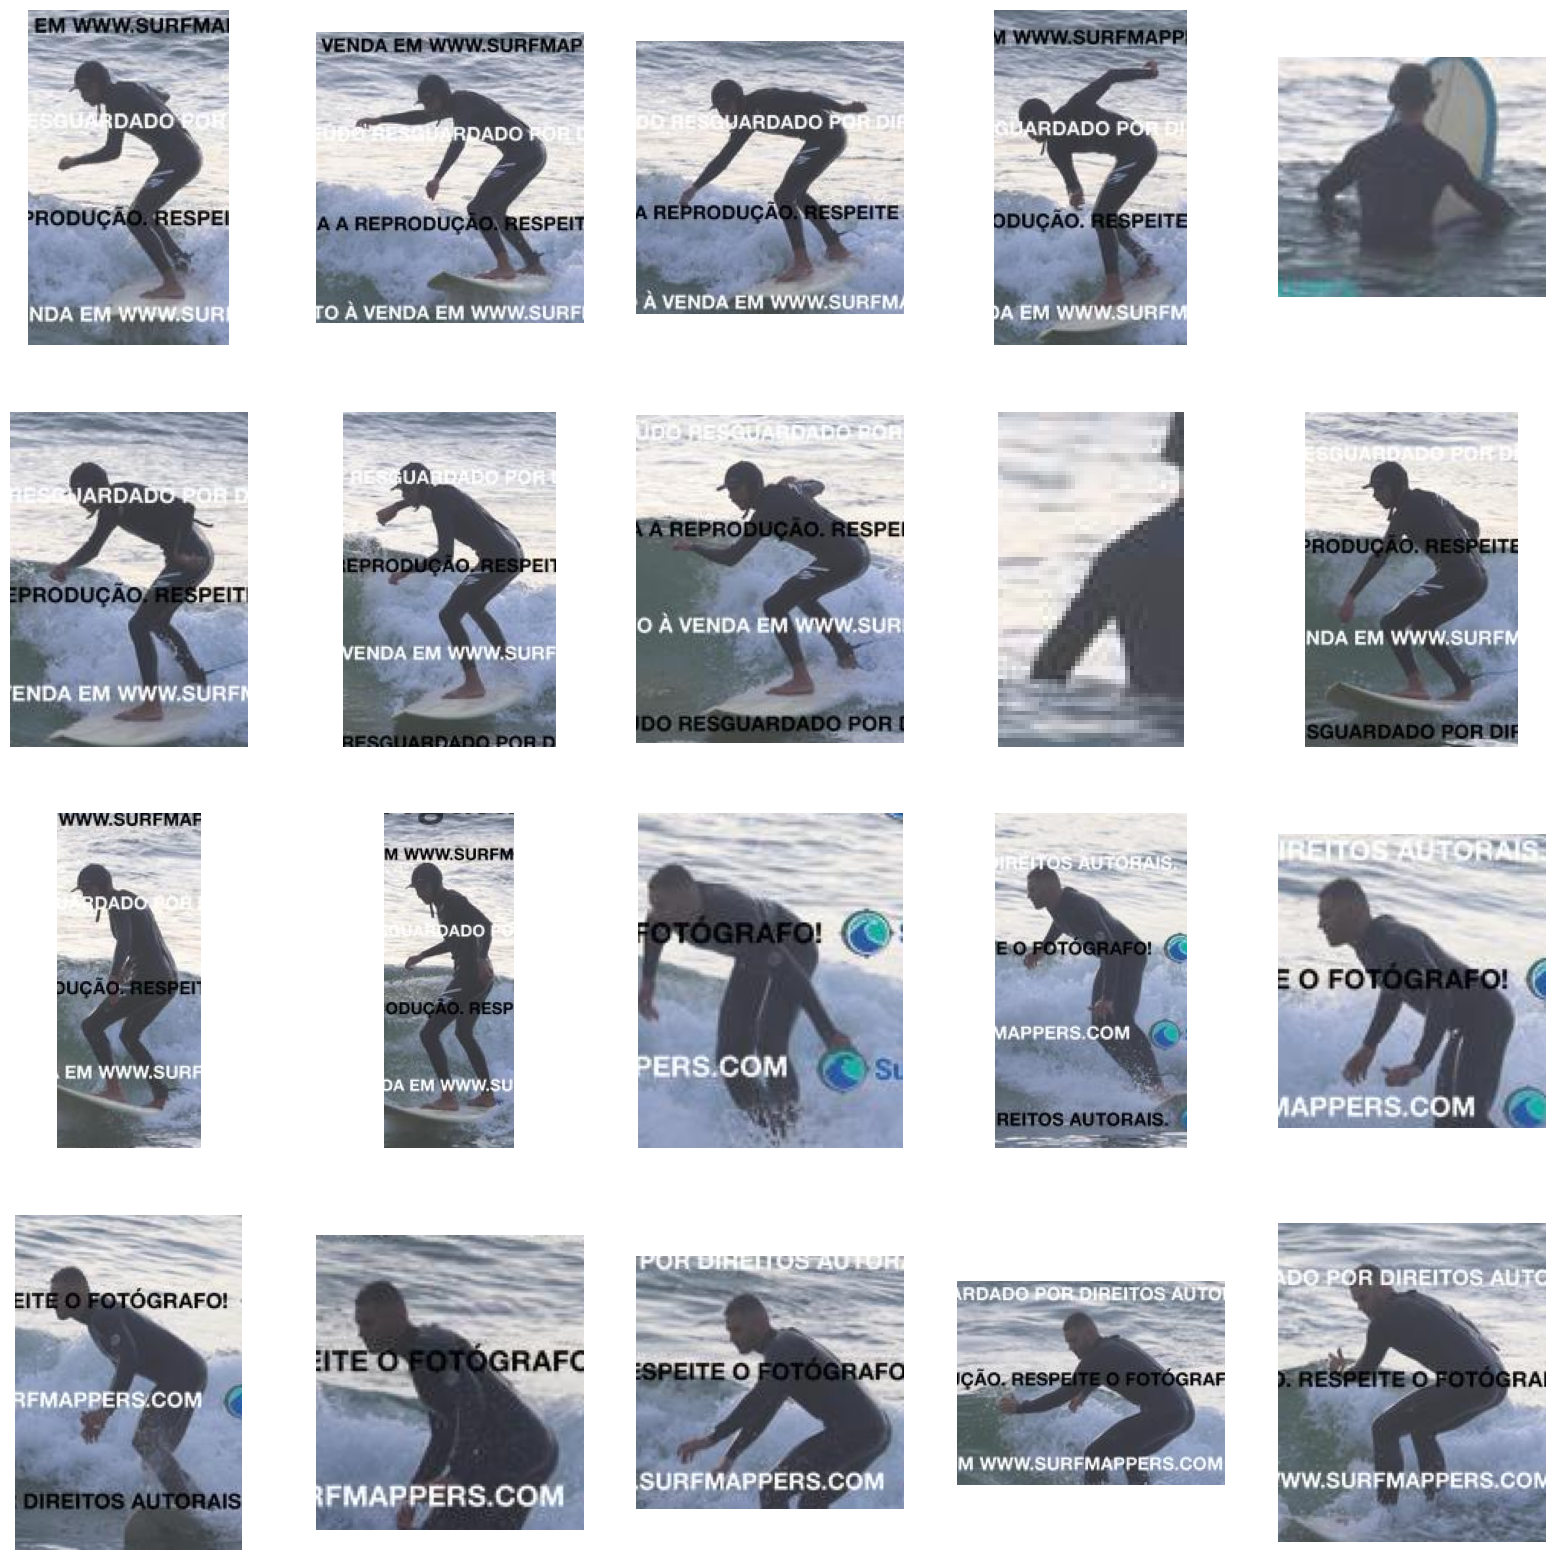

In [8]:
# show first 20 surfers
fig = plt.subplots(4, 5, figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(cv2.cvtColor(surfers_images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")

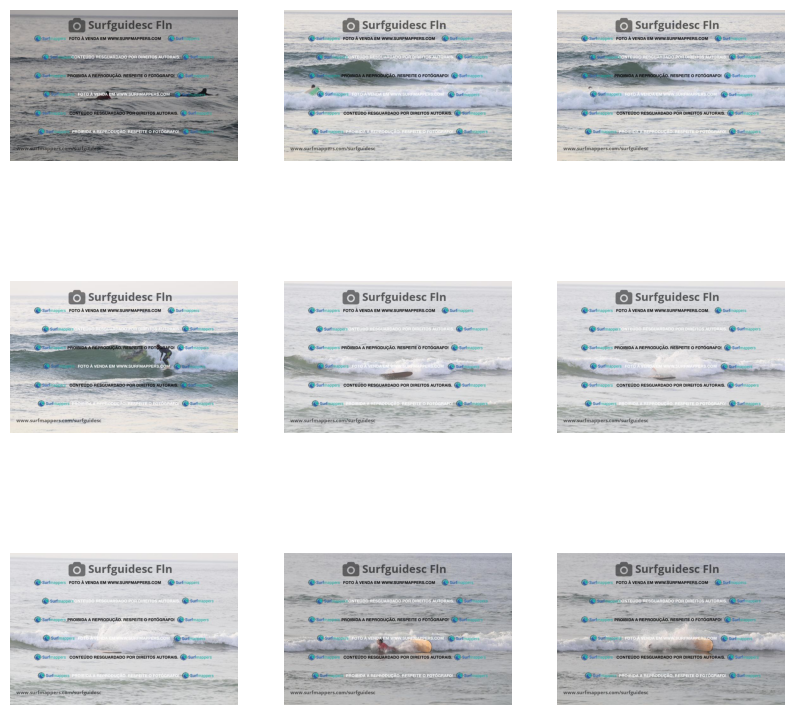

In [9]:
# Show images without surfer
fig = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(images_without_surfer)):
    plt.subplot(3, 3, i + 1)
    image = cv2.imread(images_without_surfer[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

## Extract features of the images

In [10]:
embeddings_list = []
embeddings = torch.empty(0, hidden_dim)

for surfer_image in surfers_images:
    with torch.no_grad():
        inputs = extractor(images=surfer_image, return_tensors="pt")
        outputs = model(**inputs)
        embed = outputs.last_hidden_state[0][0]
        embeddings_list.append(embed)

embeddings = torch.stack(embeddings_list, dim=0)
embeddings.size()
embeddings

tensor([[-0.9684, -0.0125,  0.0297,  ...,  2.8140,  0.4724, -1.7359],
        [-1.0961,  1.5023,  1.0239,  ...,  4.5084,  1.3207, -1.4477],
        [-2.1266,  0.4397,  1.1265,  ...,  3.1139,  0.6284, -1.7887],
        ...,
        [ 1.6658,  0.0598, -1.3443,  ...,  2.2795,  1.6815, -1.3005],
        [ 0.5613, -0.5060, -1.3290,  ...,  3.4354,  1.2290, -0.4950],
        [-0.0154, -0.2219, -1.9521,  ...,  4.0016,  1.4937, -0.8916]])

## Clusterize with KMeans

In [11]:
y_test = df.person

In [12]:
n_clusters = len(set(y_test)) - 1  # subtracting one where people was not identify
# merge embedings and cos_sim_matrix
embeddings_cos_sim_matrix = embeddings.numpy()
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
surfer_pred = kmeans.fit_predict(embeddings_cos_sim_matrix)

In [13]:
surfer_pred

array([ 2,  4,  8,  8,  3,  8,  8,  8,  0,  8,  0,  8,  2,  2,  8, 10,  8,  8,  8,  8,  8,  8,  8,  1,  1,  2,  2,  0,  4,  2,  4,  0,  8,  5,  6,  5,  6,  5,  5,  6,  6,  6,  5,  6,  6,  6,  6,  6,  6,  6,  8,  4,  4,  5,  5,  4,  8,  2,  2,  2,  2,  1,  1,  5,  5,  4,  4,  4,  4,  4,  4,  8,  8,  4,  5,  5,  1,  6,
        6,  6,  6,  1,  1,  1,  8,  2,  0,  2,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  2,  2,  4,  4,  2,  2,  4,  4, 10,  2,  2, 10,  2,  2,  2,  2,  8,  0,  0,  0,  0,  0,  0,  8,  8,  8,  8,  2,  2,  3,  3,  3,  0,  3,  3,  3,  3,  3, 10,  2,  0,  0,  7,  5,  5,  0,  6,  7,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  4, 10, 10,  4,  4,  4, 10,  1,  1,  0,  1,  1,  3,  1,  1,  1, 10,  1,  1,  6,  6,  0, 10,  1,  1,  6,  1,  6, 10, 10,  4,  4,  4, 10, 10, 10, 10,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  7,  7,
        7,  7,  7,  7,  7,  5,  5,  5,  7, 

In [14]:
df["pred1"] = df.filename.apply(
    lambda x: (
        n_clusters
        if x in images_without_surfer
        else surfer_pred[surfers_founded_mapping[x]]
    )
)
df["pred1"]

0       2
1       4
2       8
3       8
4       3
       ..
312     1
313     1
314     6
315     1
316    10
Name: pred1, Length: 317, dtype: int64

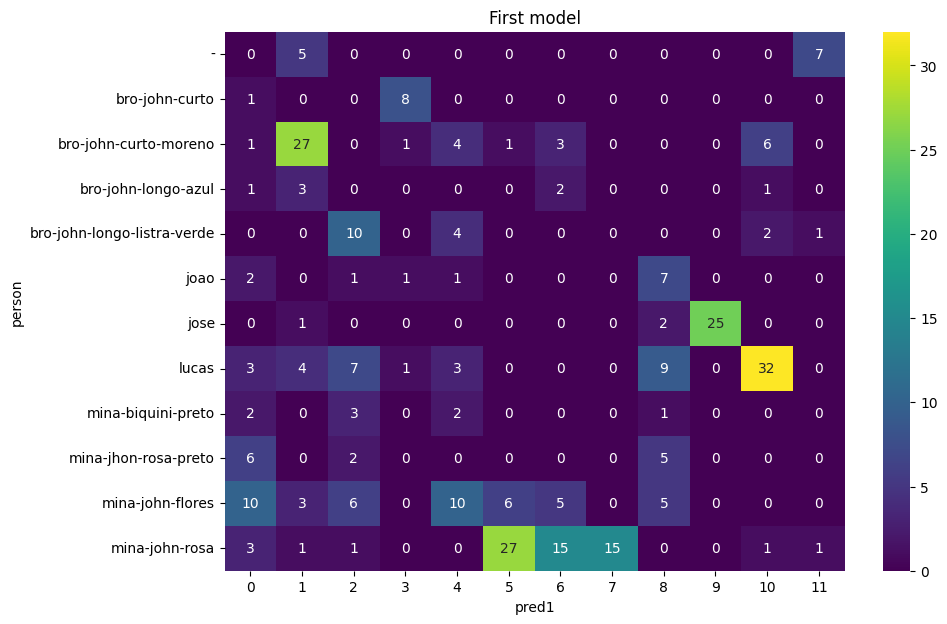

In [15]:
# Create a confusion matrix-like plot
pivot_table = pd.crosstab(
    df["person"],
    df["pred1"],
    rownames=["person"],
    colnames=["pred1"],
)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="viridis")
plt.title("First model")
plt.show()

In [16]:
adjusted_rand_score(y_test, df.pred1)

0.3055415900883346

## Similarity on neighbor images

As observed on the images before, the dataset has an order that we can use. For that we can group similar neighbor images. For that we will use the cos similarity.

In [17]:
def self_sim_matrix(a, eps=1e-8):
    a_n = a.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    sim_mt = a_norm @ a_norm.T
    return sim_mt


cos_sim_matrix = self_sim_matrix(embeddings).numpy()
cos_sim_matrix

array([[          1,     0.75359,     0.75567, ...,     0.54391,     0.70304,     0.73059],
       [    0.75359,           1,     0.91626, ...,     0.38634,     0.61468,      0.7543],
       [    0.75567,     0.91626,           1, ...,      0.3901,     0.60131,     0.74821],
       ...,
       [    0.54391,     0.38634,      0.3901, ...,           1,     0.78836,     0.68804],
       [    0.70304,     0.61468,     0.60131, ...,     0.78836,           1,     0.92516],
       [    0.73059,      0.7543,     0.74821, ...,     0.68804,     0.92516,           1]], dtype=float32)

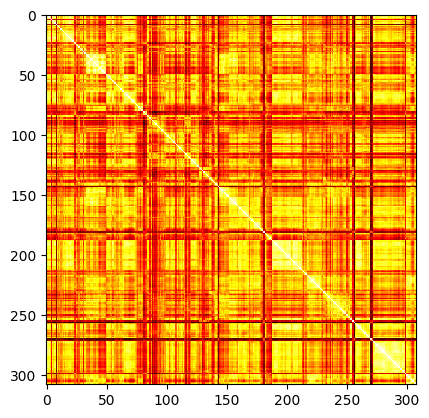

In [18]:
# plot the cosine sim matrix
plt.imshow(cos_sim_matrix, cmap="hot", interpolation="nearest")

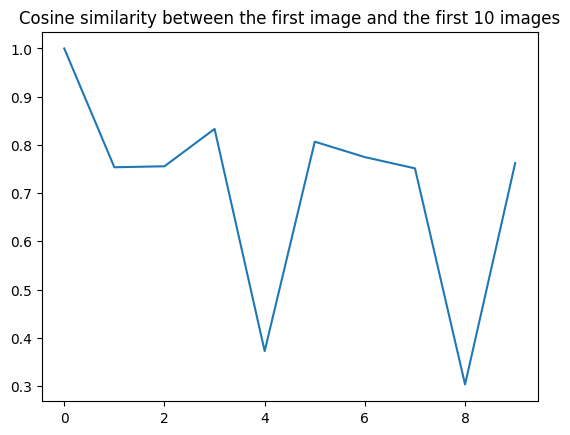

In [19]:
## plot the first 10 images similarity
plt.plot(
    cos_sim_matrix[0, :10],
)

plt.title("Cosine similarity between the first image and the first 10 images")

plt.show()

In [20]:
def find_neighboring_clusters(similarity_matrix, similarity_threshold=0.7):
    # Get the number of samples
    num_samples = similarity_matrix.shape[0]

    # Initialize a list to store clusters
    clusters = []

    # Initialize a temporary list to store the current cluster
    current_cluster = []

    # Iterate through each sample
    for i in range(num_samples):
        if current_cluster:
            # Check similarity with the last element of the current cluster
            if similarity_matrix[current_cluster[-1], i] > similarity_threshold:
                current_cluster.append(i)
            else:
                # If similarity is below the threshold, finalize the current cluster and start a new one
                if len(current_cluster) > 1:
                    clusters.append(current_cluster)
                current_cluster = [i]
        else:
            # Start the first cluster
            current_cluster.append(i)

    # Append the last cluster if it has more than one element
    if len(current_cluster) > 1:
        clusters.append(current_cluster)

    return clusters


similar_groups = find_neighboring_clusters(cos_sim_matrix, similarity_threshold=0.7)
similar_groups

[[0, 1, 2, 3],
 [5, 6, 7],
 [10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [23, 24],
 [25, 26],
 [28, 29, 30],
 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54],
 [55, 56],
 [58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76],
 [77, 78, 79, 80],
 [81, 82, 83],
 [84, 85],
 [88, 89, 90, 91, 92, 93, 94],
 [95, 96, 97],
 [98, 99, 100, 101, 102, 103, 104, 105, 106],
 [109, 110, 111, 112, 113],
 [116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126],
 [127, 128, 129],
 [131, 132, 133, 134, 135],
 [136, 137, 138],
 [140, 141, 142],
 [144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159],
 [160, 161, 162, 163, 164, 165, 166, 167, 168],
 [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180],
 [182, 183, 184, 185, 186, 187],
 [188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,

In [21]:
surfer_clustered_with_similarity = surfer_pred.copy()

for g in similar_groups:
    print(surfer_pred[g])
    print(stats.mode(surfer_pred[g]).mode)
    surfer_clustered_with_similarity[g] = stats.mode(surfer_pred[g]).mode

[2 4 8 8]
8
[8 8 8]
8
[0 8]
0
[ 2  2  8 10  8  8  8  8  8  8  8]
8
[1 1]
1
[2 2]
2
[4 2 4]
4
[5 6 5 6 5 5 6 6 6 5 6 6 6 6 6 6 6]
6
[8 4 4 5 5]
4
[4 8]
4
[2 2 2 1 1 5 5 4 4 4 4 4 4 8 8 4 5 5 1]
4
[6 6 6 6]
6
[1 1 1]
1
[8 2]
2
[0 0 0 0 0 0 0]
0
[6 0 0]
0
[ 2  2  4  4  2  2  4  4 10]
2
[10  2  2  2  2]
2
[0 0 0 0 0 8 8 8 8 2 2]
0
[3 3 3]
3
[3 3 3 3 3]
3
[10  2  0]
0
[7 5 5]
5
[6 7 6 6 5 5 5 5 5 5 5 5 5 5 5 5]
5
[ 4 10 10  4  4  4 10  1  1]
4
[ 0  1  1  3  1  1  1 10  1  1  6  6]
1
[10  1  1  6  1  6]
1
[10 10  4  4  4 10 10 10 10  8 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
10
[1 1]
1
[10  1  1  1  1  1  1  1  1  1  1  1  1  1]
1
[1 7 7 7 7 7 7 7 5 5 5 7 5 7 7 7 5 5 5]
7
[5 7]
5
[10 10]
10
[10 10 10 10 10 10  2  2  2  2 10  2 10]
10
[8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
9
[ 1  1  5  1  1  6  1 10]
1


In [22]:
df["pred2"] = df.filename.apply(
    lambda x: (
        n_clusters
        if x in images_without_surfer
        else surfer_clustered_with_similarity[surfers_founded_mapping[x]]
    )
)
df["pred2"]

0      8
1      8
2      8
3      8
4      3
      ..
312    1
313    1
314    1
315    1
316    1
Name: pred2, Length: 317, dtype: int64

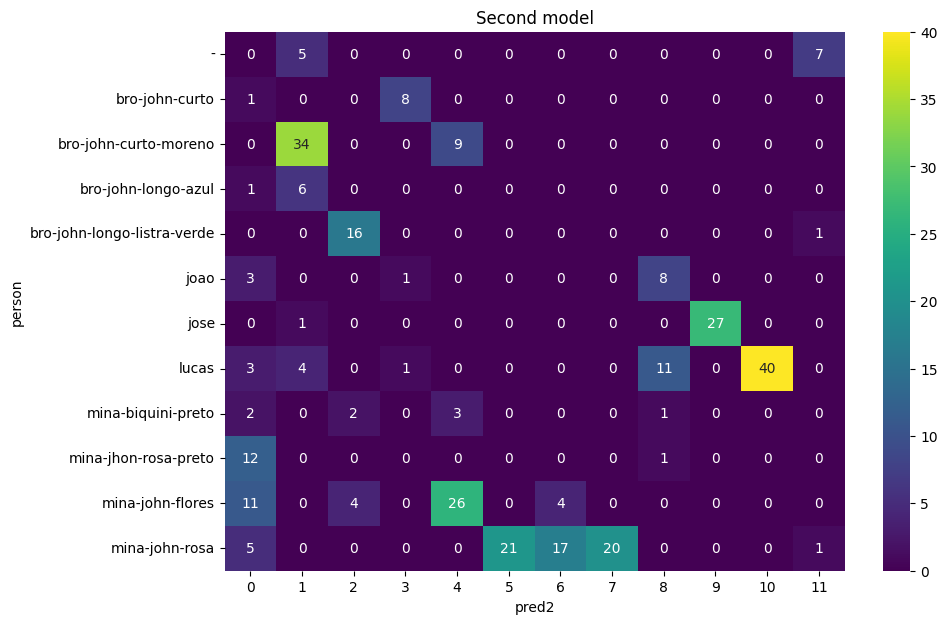

In [23]:
# Create a confusion matrix-like plot
pivot_table = pd.crosstab(
    df["person"],
    df["pred2"],
    rownames=["person"],
    colnames=["pred2"],
)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="viridis")
plt.title("Second model")
plt.show()

In [24]:
adjusted_rand_score(y_test, df.pred2)

0.4763882976899775

In [25]:
df.to_csv("dataset/results.csv", index=False)

## Improvements

- Get images better quality and without watermark (direct from photographers).
- Improve surfer detection.
- Change classification to multiclass.
- Test other clustering algorithms.